In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from functions.models import LinearModel, NonLinearModel, RidgeModel, LassoModel
from functions.preprocess import DataLoader, NumericalFeaturesDataCleaner, CategoricalFeaturesDataCleaner, CreateDummies
from functions.preprocess import year_group, safety_level, neigh_crime, has_ac_pool, square_met_2, neigh_safety 
import warnings
warnings.filterwarnings("ignore")


# Load Data
---
Load data and split

In [63]:
data_loader = DataLoader(path='train.csv', columns_to_drop=['orientation', 'num_supermarkets', 'door'])
df_train, df_test = data_loader.load_and_split()

- Dropping the NaN values here could serve as a strategy since the number of nulls is not significant. This approach would allow us to estimate the model parameters without introducing any bias. Later, for predictions, we will need to impute the NaN values or the inconsistent ones as negative values. However, the predictions will be based on coefficients that are not biased by the imputation method.

- We have also conducted some trials without dropping the NaN values, opting instead to impute them. When comparing the results, there is not much difference.

In [64]:
df_test = df_test.dropna()
df_train = df_train.dropna()

# Clean and Transform the features
----

In [65]:
df_transformer_train = NumericalFeaturesDataCleaner(df_train)
df_transformer_test = NumericalFeaturesDataCleaner(df_test)
df_train = df_transformer_train.process_all()
df_test = df_transformer_test.process_all()

categorical_columns = ['is_furnished', 'has_ac', 'has_pool', 'neighborhood']
df_transformer_train = CategoricalFeaturesDataCleaner(df_train, categorical_columns)
df_transformer_test = CategoricalFeaturesDataCleaner(df_test, categorical_columns)
df_train = df_transformer_train.process_all()
df_test = df_transformer_test.process_all()

# Create Dummies
---

In [66]:
ordinal_columns = ['num_crimes', 'num_rooms', 'num_baths']
dummy_creator_train = CreateDummies(df=df_train, ordinal_columns=ordinal_columns, categorical_columns=categorical_columns)
dummy_creator_test = CreateDummies(df=df_test, ordinal_columns=ordinal_columns, categorical_columns=categorical_columns, encoder=dummy_creator_train.encoder)

df_train = dummy_creator_train.process_all(fit=True)
df_test = dummy_creator_test.process_all(fit=False)

# Feature Engineering
---

In [67]:
functions_to_apply = [year_group, safety_level, neigh_crime, has_ac_pool, square_met_2, neigh_safety]

for func in functions_to_apply:
    df_train = func(df_train)

for func in functions_to_apply:
    df_train = func(df_test) 

# Check Nulls
---

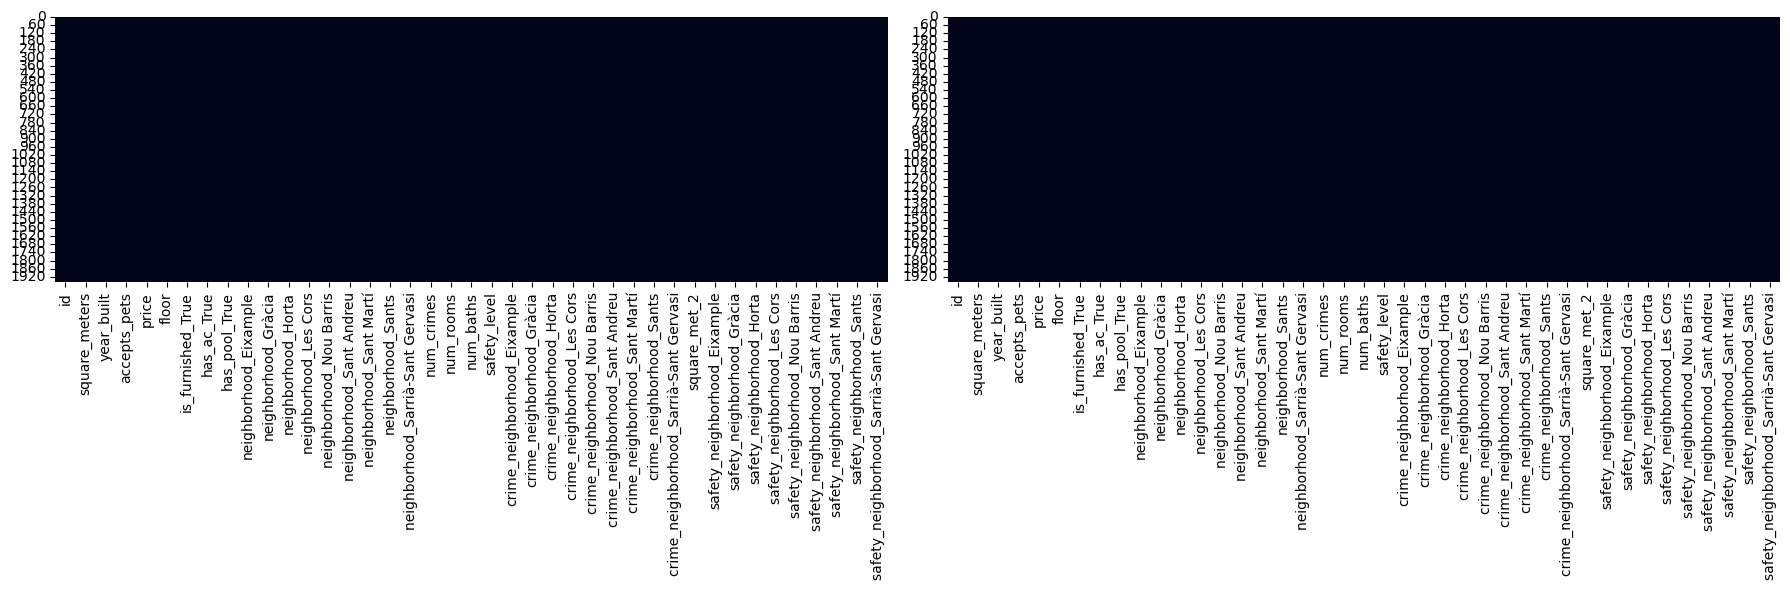

In [68]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
sns.heatmap(df_train.isnull(), cbar=False, ax=axes[0])
sns.heatmap(df_test.isnull(), cbar=False, ax=axes[1])

plt.tight_layout()
plt.show()

### Define different combinations of features to iterate:

In [69]:
df_train.columns

Index(['id', 'square_meters', 'year_built', 'accepts_pets', 'price', 'floor',
       'is_furnished_True', 'has_ac_True', 'has_pool_True',
       'neighborhood_Eixample', 'neighborhood_Gràcia', 'neighborhood_Horta',
       'neighborhood_Les Cors', 'neighborhood_Nou Barris',
       'neighborhood_Sant Andreu', 'neighborhood_Sant Martí',
       'neighborhood_Sants', 'neighborhood_Sarrià-Sant Gervasi', 'num_crimes',
       'num_rooms', 'num_baths', 'safety_level', 'crime_neighborhood_Eixample',
       'crime_neighborhood_Gràcia', 'crime_neighborhood_Horta',
       'crime_neighborhood_Les Cors', 'crime_neighborhood_Nou Barris',
       'crime_neighborhood_Sant Andreu', 'crime_neighborhood_Sant Martí',
       'crime_neighborhood_Sants', 'crime_neighborhood_Sarrià-Sant Gervasi',
       'square_met_2', 'safety_neighborhood_Eixample',
       'safety_neighborhood_Gràcia', 'safety_neighborhood_Horta',
       'safety_neighborhood_Les Cors', 'safety_neighborhood_Nou Barris',
       'safety_neighborho

In [70]:
target_column = 'price'
features = ['num_crimes','num_rooms', 'num_baths','square_meters', 'floor', 'neighborhood_Eixample', 'neighborhood_Gràcia', 'neighborhood_Horta',
       'neighborhood_Les Cors', 'neighborhood_Nou Barris',
       'neighborhood_Sant Andreu', 'neighborhood_Sant Martí',
       'neighborhood_Sants', 'neighborhood_Sarrià-Sant Gervasi','crime_neighborhood_Eixample',
       'crime_neighborhood_Gràcia', 'crime_neighborhood_Horta',
       'crime_neighborhood_Les Cors', 'crime_neighborhood_Nou Barris',
       'crime_neighborhood_Sant Andreu', 'crime_neighborhood_Sant Martí',
       'crime_neighborhood_Sants', 'crime_neighborhood_Sarrià-Sant Gervasi']
features_2 = ['num_crimes','num_rooms', 'num_baths','square_meters', 'square_met_2','floor', 'neighborhood_Eixample', 'neighborhood_Gràcia', 'neighborhood_Horta',
       'neighborhood_Les Cors', 'neighborhood_Nou Barris',
       'neighborhood_Sant Andreu', 'neighborhood_Sant Martí',
       'neighborhood_Sants', 'neighborhood_Sarrià-Sant Gervasi',
       'safety_neighborhood_Eixample',
       'safety_neighborhood_Gràcia', 'safety_neighborhood_Horta',
       'safety_neighborhood_Les Cors', 'safety_neighborhood_Nou Barris',
       'safety_neighborhood_Sant Andreu', 'safety_neighborhood_Sant Martí',
       'safety_neighborhood_Sants', 'safety_neighborhood_Sarrià-Sant Gervasi']
features_3 = ['square_meters', 'year_built', 'accepts_pets', 'floor',
       'is_furnished_True', 'has_ac_True', 'has_pool_True',
       'neighborhood_Eixample', 'neighborhood_Gràcia', 'neighborhood_Horta',
       'neighborhood_Les Cors', 'neighborhood_Nou Barris',
       'neighborhood_Sant Andreu', 'neighborhood_Sant Martí',
       'neighborhood_Sants', 'neighborhood_Sarrià-Sant Gervasi', 'num_crimes',
       'num_rooms', 'num_baths', 'safety_level',
       'square_met_2', 'safety_neighborhood_Eixample',
       'safety_neighborhood_Gràcia', 'safety_neighborhood_Horta',
       'safety_neighborhood_Les Cors', 'safety_neighborhood_Nou Barris',
       'safety_neighborhood_Sant Andreu', 'safety_neighborhood_Sant Martí',
       'safety_neighborhood_Sants', 'safety_neighborhood_Sarrià-Sant Gervasi']

## **Linear model**


In [71]:
hyperparameters = None
target_column = 'price'
model_linear = LinearModel(features_3, target_column, hyperparameters)
model_linear.train_model(df_train)
predictions = model_linear.predict_model(df_test)
# Evaluar el modelo
mse = model_linear.evaluate_model(df_test)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 29043.0


### **Feature Importance:**

As we can observe, ```ssquare meters```,```num_crimes```, ```floor```, ```num_rooms```, some ```neighborhoods```, and the interaction of ```safety``` and neighborhood are the most significant variables to explain the variability on ```price```.

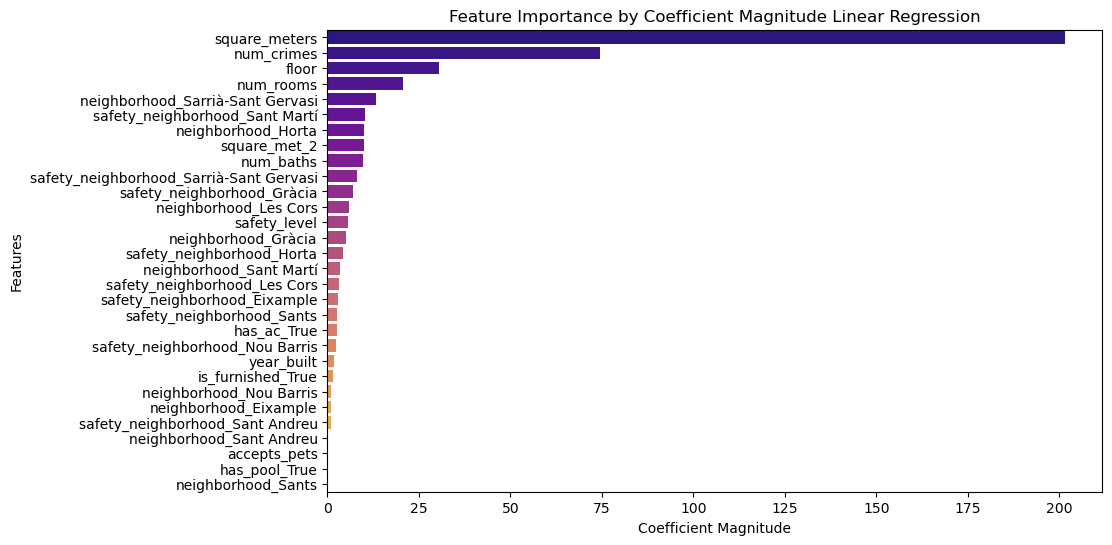

In [72]:
coefficients = model_linear.model.coef_  
coef_df = pd.DataFrame({
    'Feature': features_3,
    'Coefficient': abs(coefficients)
}).sort_values(by='Coefficient', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='plasma')
plt.title('Feature Importance by Coefficient Magnitude Linear Regression')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Features')
plt.show()

## **Ridge**


In [73]:
param_grid = {'alpha': [0.1, 0.2, 0.3, 0.9,1,1.1,1.2,1.4,1.5,1.6,2, 3,4,5, 6, 7, 8, 9, 10, 20, 22,25,40]}
ridge_model = RidgeModel(features_3, target_column)

ridge_model.train_model(df_train, param_grid=param_grid)
predictions = ridge_model.predict_model(df_test)
mse = ridge_model.evaluate_model(df_test)
print("Best parameters:", ridge_model.best_params)
print("MSE:", mse)

Best parameters: {'alpha': 4}
MSE: 29049.52435756444


### **Feature Importance Ridge**

----


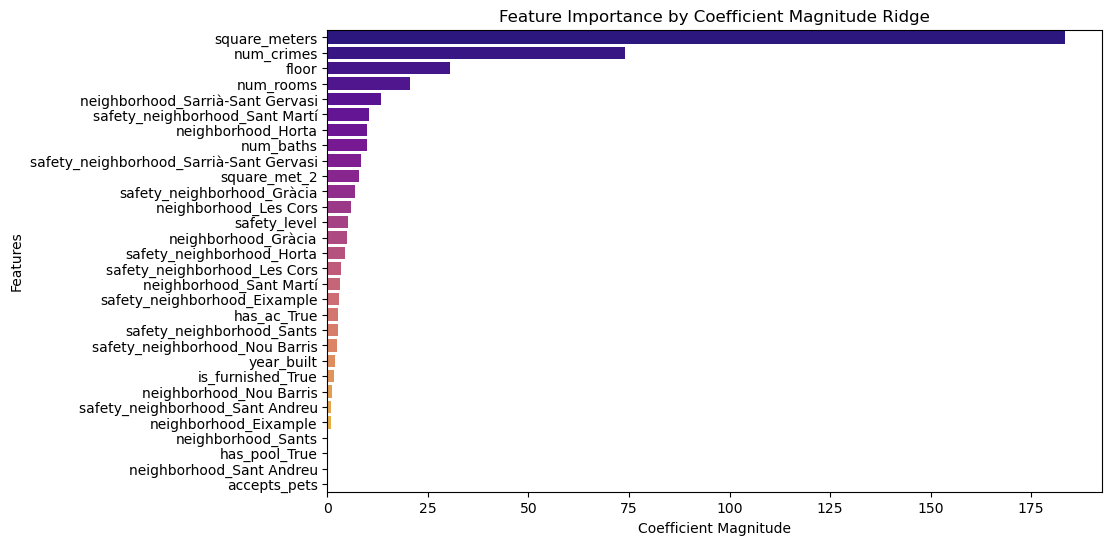

In [74]:
coefficients = ridge_model.model.coef_  
coef_df = pd.DataFrame({
    'Feature': features_3,
    'Coefficient': abs(coefficients)
}).sort_values(by='Coefficient', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='plasma')
plt.title('Feature Importance by Coefficient Magnitude Ridge')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Features')
plt.show()

## **Lasso**
----

In [75]:
param_grid = {'alpha': [0.1, 0.2, 0.3, 0.9,1,1.1,1.2,1.4,1.5,1.6,2, 3,4,5, 6, 7, 8, 9, 10, 20, 22,25,40]}
lasso_model = LassoModel(features_3, target_column)

lasso_model.train_model(df_train, param_grid=param_grid)
predictions = lasso_model.predict_model(df_test)
mse = ridge_model.evaluate_model(df_test)
print("Best parameters:", ridge_model.best_params)
print("MSE:", mse)

Best parameters: {'alpha': 4}
MSE: 29049.52435756444


### **Feature Importance **
---

With Lasso, we can see how penalization reduces to zero the coefficients of features that do not contribute predictive power to the price.

Under this model we can see that the relevant features are square_meters, num_crimes, floor, num_rooms, num_baths, and some interactions between crimes and neighborhood.

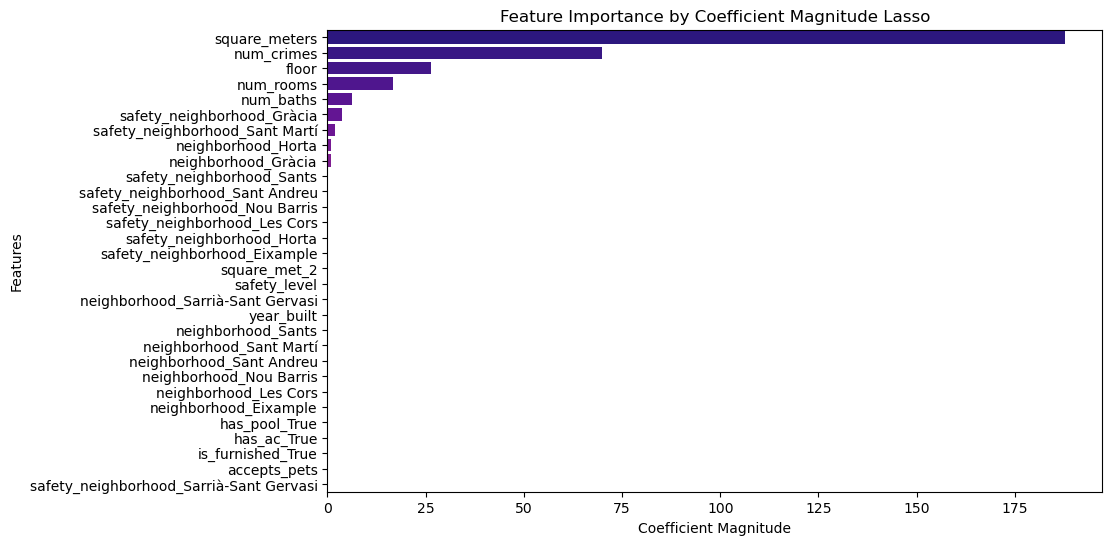

In [76]:
coefficients = lasso_model.model.coef_  
coef_df = pd.DataFrame({
    'Feature': features_3,
    'Coefficient': abs(coefficients)
}).sort_values(by='Coefficient', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='plasma')
plt.title('Feature Importance by Coefficient Magnitude Lasso')
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Features')
plt.show()

## **Non Linear Models**
---

In [52]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import numpy as np

param_grids = {
    DecisionTreeRegressor: {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    RandomForestRegressor: {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    GradientBoostingRegressor: {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    },
    xgb.XGBRegressor: {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7]
    }
}

models = {
    'Decision Tree': DecisionTreeRegressor,
    'Random Forest': RandomForestRegressor,
    'Gradient Boosting': GradientBoostingRegressor,
    'XGBoost': xgb.XGBRegressor
}

best_models = {}
best_mse = np.inf
best_model_name = None
best_model_features = None

for model_name, model_class in models.items():    
    param_grid = param_grids[model_class]
    model_instance = NonLinearModel(model_class, features, target_column)
    
    model_instance.train_model(df_train, param_grid)

    mse = model_instance.evaluate_model(df_test)

    if mse < best_mse:
        best_mse = mse
        best_model_name = model_name
        best_model = model_instance
        best_model_features = features 
    
    best_models[model_name] = (model_instance.model, model_instance.best_params, mse)
    print(f"Best parameters for {model_name}:", model_instance.best_params)
    print(f"MSE for {model_name}:", mse)

print(f"\nThe best model is: {best_model_name} with features {best_model_features} and an MSE of {best_mse}")



Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_split': 10}
MSE for Decision Tree: 30091.954591242087
Best parameters for Random Forest: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100}
MSE for Random Forest: 28252.25691774398
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
MSE for Gradient Boosting: 28045.044293979736
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}
MSE for XGBoost: 28165.18742031047

The best model is: Gradient Boosting with features ['num_crimes', 'num_rooms', 'num_baths', 'square_meters', 'floor', 'neighborhood_Eixample', 'neighborhood_Gràcia', 'neighborhood_Horta', 'neighborhood_Les Cors', 'neighborhood_Nou Barris', 'neighborhood_Sant Andreu', 'neighborhood_Sant Martí', 'neighborhood_Sants', 'neighborhood_Sarrià-Sant Gervasi', 'crime_neighborhood_Eixample', 'crime_neighborhood_Gràcia', 'crime_neighborhood_Horta', 'crime_neighborhood_Les Cors', 'cr

### **Feature Importance**
---

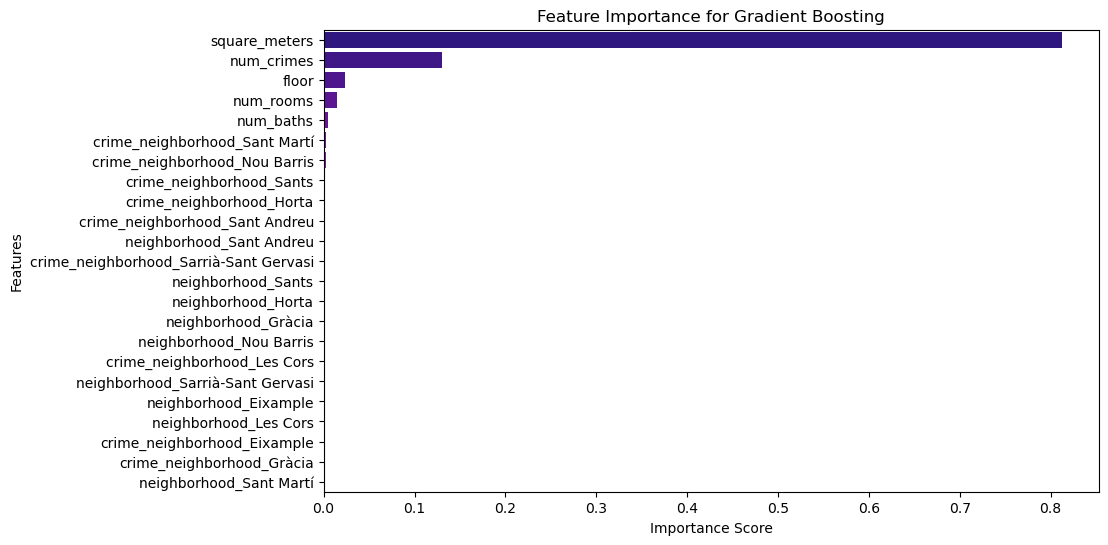

In [53]:
if hasattr(best_model.model, 'feature_importances_'):
    importances = best_model.model.feature_importances_
    feature_names = best_model.features_columns 
    
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='plasma')
    plt.title(f'Feature Importance for {best_model_name}')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()
else:
    print("El mejor modelo no tiene atributos de importancia de características.")


## **Predictions**
----


In [77]:
df = pd.read_csv('test.csv')
df['floor'] = df['door'].str.extract(r'(\d{1,2})º')
df = df.drop(columns = ['orientation', 'num_supermarkets', 'door'], axis=1)

In [78]:
df_transformer = NumericalFeaturesDataCleaner(df)
df = df_transformer.process_all()
df_transformer_cat = CategoricalFeaturesDataCleaner(df, categorical_columns)
df = df_transformer_cat.process_all()
dummy_creator = CreateDummies(df=df, ordinal_columns=ordinal_columns, categorical_columns=categorical_columns)
df = dummy_creator.process_all()

In [79]:
functions_to_apply = [year_group, safety_level, neigh_crime, has_ac_pool, square_met_2, neigh_safety]
for func in functions_to_apply:
    df = func(df)

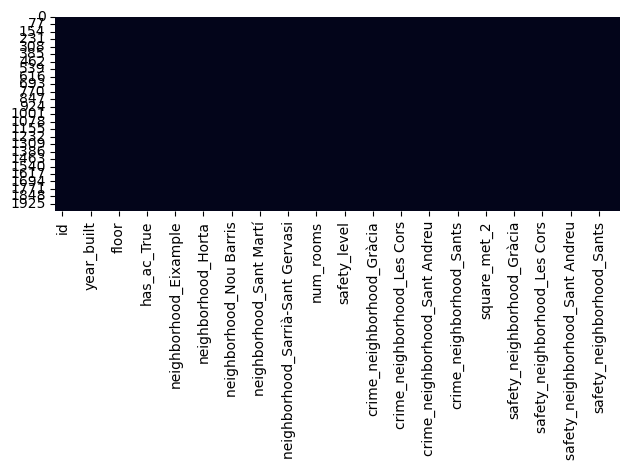

In [80]:
sns.heatmap(df.isnull(), cbar=False)

plt.tight_layout()
plt.show()

Ridge Predictions

In [81]:
df['price'] = ridge_model.predict_model(df[features_3])
predictions_output = df[['id', 'price']]
predictions_output.to_csv('predictions/predictions_ridge_model_4.csv', index=False)
print(predictions_output)

        id        price
0     6253  1365.181259
1     4685  1032.330781
2     1732  1016.260470
3     4743  1323.087382
4     4522  1109.365893
...    ...          ...
1995  6413  1090.240124
1996  8286  1198.849533
1997  7854  1210.771734
1998  1096  1251.734196
1999  6930   847.572435

[2000 rows x 2 columns]


Lasso Predictions

In [82]:
df['price'] = lasso_model.predict_model(df[features_3])
predictions_output = df[['id', 'price']]
predictions_output.to_csv('predictions/predictions_lasso_model_4.csv', index=False)
print(predictions_output)

        id        price
0     6253  1373.667275
1     4685  1035.285253
2     1732  1022.917945
3     4743  1324.510199
4     4522  1113.699937
...    ...          ...
1995  6413  1079.388771
1996  8286  1217.128357
1997  7854  1190.335674
1998  1096  1264.272554
1999  6930   851.098700

[2000 rows x 2 columns]


Non Linear Predictions

In [60]:
df['price'] = best_model.predict_model(df[features])
predictions_output = df[['id', 'price']]
predictions_output.to_csv('predictions/predictions_nonlinear_3.csv', index=False)
print(predictions_output)

        id        price
0     6253  1406.902893
1     4685  1027.187346
2     1732   995.197648
3     4743  1303.321870
4     4522  1110.061110
...    ...          ...
1995  6413  1101.810450
1996  8286  1243.573607
1997  7854  1189.180683
1998  1096  1286.835880
1999  6930   841.223456

[2000 rows x 2 columns]


Linear Predictions

In [83]:
df['price'] = model_linear.predict_model(df[features_3])
predictions_output = df[['id', 'price']]
predictions_output.to_csv('predictions/predictions_linear_4.csv', index=False)
print(predictions_output)

        id        price
0     6253  1364.297135
1     4685  1034.551888
2     1732  1017.608380
3     4743  1319.756492
4     4522  1111.585946
...    ...          ...
1995  6413  1092.280270
1996  8286  1195.685946
1997  7854  1213.742953
1998  1096  1250.560557
1999  6930   843.052784

[2000 rows x 2 columns]


# Conclusion
---

Based on the results obtained from our Kaggle competition, Lasso regression has proven to be the model with the best predictive performance for our target variable. Despite this success, the dataset does not exhibit strong patterns related to the target variable. This lack of discernible trends may be attributed to the synthetic nature of the data, which complicates the identification of intuitive insights that could be derived from the exploratory data analysis (EDA).

Through the application of Lasso, we have identified several significant features that contribute to the model's predictive capabilities. These features include square_meters, num_crimes, floor, num_rooms, and num_baths. The relevance of these variables underscores the importance of size and amenities in determining prices, while also highlighting the nuanced influence of crime rates on property values.

In summary, while Lasso regression provides a robust predictive framework, the challenges posed by the synthetic dataset emphasize the need for careful consideration when interpreting results and extracting actionable insights for real-world applications.